In [1]:
import pandas as pd                                         #Data scientist starter pack
import numpy as np
from matplotlib import pyplot as plt
import math

from collections import Counter                             #Some useful tools 
from functools import reduce

import seaborn as sns                                       #More on plotting

import torch as trc                                         #To set PyTorch framework
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv1d, MaxPool1d, Module, Softmax, BatchNorm1d, Dropout
import torch.nn.functional as func
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split        #Tool to fast build validation set

from datetime import datetime                               #To deal with datetime objects

import string                                               #Some useful string tools
import nltk                                                 #Natural language processing libraries
import spacy
import re                                                   #Regex tools

import random as rdm                                        #Simulation tools
import time                                                 #Ticking away the moments that make up a dull day

from tqdm import tqdm                                       #Te quiero desmasiado 

c:\Users\Leonardo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### *Dow Jones dataset: explorative data analysis and first feature engineering*

We don't need all the columns for our task, so we are going to load only the relevant columns, that are the opening value of the index and its closing value.

In [2]:
dow_jones = pd.read_csv('datasets/upload_DJIA_table.csv', usecols=['Date','Open','Close'])

In [3]:
dow_jones.head(10)

,Date,Open,Close
0,2016-07-01,17924.240234,17949.369141
1,2016-06-30,17712.759766,17929.990234
2,2016-06-29,17456.019531,17694.679688
3,2016-06-28,17190.509766,17409.720703
4,2016-06-27,17355.210938,17140.240234
5,2016-06-24,17946.630859,17400.750000
6,2016-06-23,17844.109375,18011.070312
7,2016-06-22,17832.669922,17780.830078
8,2016-06-21,17827.330078,17829.730469
9,2016-06-20,17736.869141,17804.869141


In [4]:
dow_jones.isna().sum()

Date     0
Open     0
Close    0
dtype: int64

In [5]:
dow_jones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1989 entries, 0 to 1988
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1989 non-null   object 
 1   Open    1989 non-null   float64
 2   Close   1989 non-null   float64
dtypes: float64(2), object(1)
memory usage: 46.7+ KB


The Dow Jones dataset seems consistent. Now let's build a column with a label that express the ground thruth over which we are going to buil our model:
- 1 express that the DJIA closed increasing over the opening value or at least remained the same;
- 0 express that the DJIA closed decreasing over the opening value.

In [5]:
ground_truth = []
for idx in dow_jones.index:
    if dow_jones.iloc[idx].Close >= dow_jones.iloc[idx].Open:
        ground_truth.append(1)
    else:
        ground_truth.append(0)

In [6]:
dow_jones['Label'] = ground_truth

Now let's plot some charts to have a glimpse at the data visualization. We can look at the distribution of our new feature to discover if it is well balanced and we can have a look to the general trend of the opening-closing pairs. 

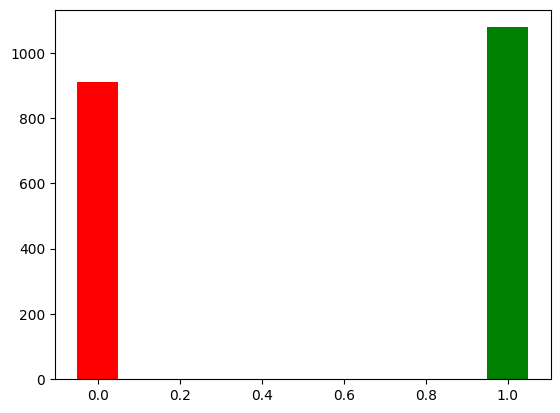

In [35]:
ax = plt.subplot(111)
ax.bar(dow_jones['Label'].unique(), dow_jones['Label'].value_counts(), width=0.1, color=['green','red'])
plt.show()

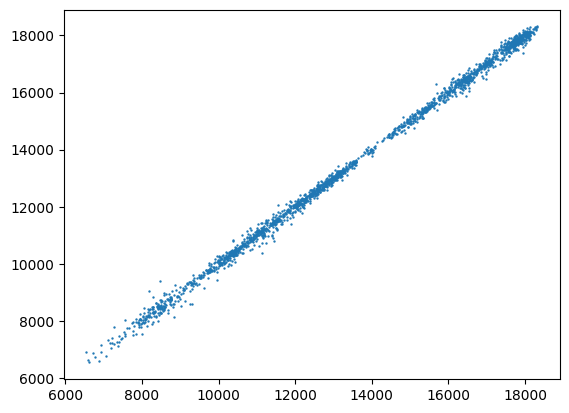

In [36]:
plt.scatter(dow_jones.Open, dow_jones.Close, s = 0.5)

We can see that our labels are quiet well balanced and that there's an expected strong linear correlation between opening DJIA and closening DJIA.

### *Newstitle dataset: explorative data analysis and text preprocessing*

In [7]:
news = pd.read_csv('datasets/RedditNews.csv')

In [8]:
news.head(10)

,Date,News
0,2016-07-01,A 117-year-old woman in Mexico City finally re...
1,2016-07-01,IMF chief backs Athens as permanent Olympic host
2,2016-07-01,"The president of France says if Brexit won, so..."
3,2016-07-01,British Man Who Must Give Police 24 Hours' Not...
4,2016-07-01,100+ Nobel laureates urge Greenpeace to stop o...
5,2016-07-01,Brazil: Huge spike in number of police killing...
6,2016-07-01,Austria's highest court annuls presidential el...
7,2016-07-01,"Facebook wins privacy case, can track any Belg..."
8,2016-07-01,Switzerland denies Muslim girls citizenship af...
9,2016-07-01,China kills millions of innocent meditators fo...


Now we are just going to check if the dataset is consistent.

In [10]:
news.isna().sum()

Date    0
News    0
dtype: int64

So we can proceed to build a view of the dataset where we group by the date and then build a new feature from joining all the preprocessed newstitles. This function leverages NLTK library and do the whole text-preprocessing: punctuation and stop-words removal, tokenization and stemming. We are also excluding only-digits words and word shorter than 3 characters.

In [9]:
def text_preprocesser(text:string)->list:
    tokenized = nltk.word_tokenize(''.join([char 
                                       for char 
                                       in text.lower() 
                                       if char not in string.punctuation]))
                                       
    stop_words = nltk.corpus.stopwords.words('english')
    no_stop_words = [word 
                     for word 
                     in tokenized 
                     if word not in stop_words]

    stemmer = nltk.stem.porter.PorterStemmer()

    return [stemmer.stem(word)
            for word 
            in no_stop_words
            if any(chr.isdigit() for chr in word) == False and len(word) > 3]

In [10]:
documents = {}
for date in tqdm(news.Date.unique()):
    processed = []
    for text in news.News[news.Date == date]:
        processed += text_preprocesser(text)
    documents[date] = processed

100%|██████████| 2943/2943 [00:50<00:00, 58.73it/s]


In [11]:
newers = pd.DataFrame({'Date':documents.keys(),
                      'Preprocessed News':documents.values()})

In [12]:
newers.head()

,Date,Preprocessed News
0,2016-07-01,"[woman, mexico, citi, final, receiv, birth, ce..."
1,2016-06-30,"[jamaica, propos, marijuana, dispens, tourist,..."
2,2016-06-29,"[explos, airport, istanbul, yemeni, former, pr..."
3,2016-06-28,"[scientist, australia, want, save, great, barr..."
4,2016-06-27,"[barclay, share, suspend, trade, tank, pope, s..."


### *Our dataset: joining the previous work into a projection of the data of interest*

In [13]:
final_dataset = dow_jones.merge(newers)
final_dataset = final_dataset.drop(labels=['Open','Close'], axis=1)

In [14]:
final_dataset.head(10)

,Date,Label,Preprocessed News
0,2016-07-01,1,"[woman, mexico, citi, final, receiv, birth, ce..."
1,2016-06-30,1,"[jamaica, propos, marijuana, dispens, tourist,..."
2,2016-06-29,1,"[explos, airport, istanbul, yemeni, former, pr..."
3,2016-06-28,1,"[scientist, australia, want, save, great, barr..."
4,2016-06-27,0,"[barclay, share, suspend, trade, tank, pope, s..."
5,2016-06-24,0,"[david, cameron, resign, referendum, forecast,..."
6,2016-06-23,1,"[today, unit, kingdom, decid, whether, remain,..."
7,2016-06-22,0,"[german, govern, agre, frack, indefinit, teena..."
8,2016-06-21,1,"[australian, athlet, compet, paralymp, game, r..."
9,2016-06-20,1,"[stagger, percent, venezuelan, money, enough, ..."


__________________________

### *Some more feature engineering: feature extraction from preprocessed text*

The next step is to define a proper feature extraction for the preprocessed text. Good ideas for this are two basic procedures in text mining:

- *TFIDF* -> sintactically vectorization of the documents;

- *Word2vec* -> more semantically sensitive procedure to vectorize documents. 

The approach will be to test on these two feature extraction to eventually retrieve more specifically features. Then we are going to test both on different types of binary classifiers, and we will choose the one with the best performances with respect to accuracy and auroc metrics. 

#### *TFIDF vectorization from scratch*

We need to define some partial outputs:
- Vocabulary -> it contains all the words in the corpus mapped to progressive integers;
- IDF -> it is a vector where each of the words is weighted with respect to its frequency $n_i$ in the corpus of $n$ documents: IDF for the i-th word is $IDF_i = log_{10} \frac{n}{n_i}$
- TFIDF -> we are going to vectorize each word with normalized frequency weighted with respect to the linked IDF.

In [15]:
listOfWords = []
for index in final_dataset.index:
    listOfWords += final_dataset['Preprocessed News'][index]

vocabulary = {}
term_id = 1
for word in sorted(list(set(listOfWords))):
    vocabulary[word] = term_id
    term_id += 1

word_occ = {}
for idx in final_dataset.index:
    setted = set(final_dataset['Preprocessed News'][idx])
    for word in setted:
        if word not in word_occ:
            word_occ[word] = 1
        else:
            word_occ[word] += 1

idf = {}
L = len(final_dataset['Preprocessed News'])
for word in sorted(word_occ.keys()):
    idf[word] = math.log10(L/word_occ[word])

tfidf_inverted_index = {}
for index, list_ in final_dataset['Preprocessed News'].iteritems():
    counter = Counter(list_)
    for word in set(list_):
        tf_idf = counter[word]*idf[word]/len(list_)
        if vocabulary[word] in tfidf_inverted_index:
            tfidf_inverted_index[vocabulary[word]].append((index, tf_idf))
        else:
            tfidf_inverted_index[vocabulary[word]] = [(index, tf_idf)]

Now that we have a tfidf based inverted index, we can build the vectorization of the preprocessed news. 

In [16]:
vectorization = []
for idx in tqdm(final_dataset.index):
    vectorized = np.zeros(len(vocabulary))
    for word in final_dataset['Preprocessed News'][idx]:
        if word in vocabulary.keys():
            for tup in tfidf_inverted_index[vocabulary[word]]:
                if tup[0] == idx:
                    vectorized[vocabulary[word]-1] = tup[1]
    vectorization.append(vectorized)

100%|██████████| 1989/1989 [00:24<00:00, 81.76it/s] 


In [17]:
final_dataset['TFIDF Vectorization'] = vectorization 

In [18]:
final_dataset.head(10)

,Date,Label,Preprocessed News,TFIDF Vectorization
0,2016-07-01,1,"[woman, mexico, citi, final, receiv, birth, ce...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2016-06-30,1,"[jamaica, propos, marijuana, dispens, tourist,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2016-06-29,1,"[explos, airport, istanbul, yemeni, former, pr...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,2016-06-28,1,"[scientist, australia, want, save, great, barr...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,2016-06-27,0,"[barclay, share, suspend, trade, tank, pope, s...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,2016-06-24,0,"[david, cameron, resign, referendum, forecast,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,2016-06-23,1,"[today, unit, kingdom, decid, whether, remain,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,2016-06-22,0,"[german, govern, agre, frack, indefinit, teena...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,2016-06-21,1,"[australian, athlet, compet, paralymp, game, r...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,2016-06-20,1,"[stagger, percent, venezuelan, money, enough, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


The authour of the dataset suggests a way to split the dataset into the train-set and the test-set respecting the 80/20 proportion:
- Training Set: from 2008-08-08 to 2014-12-31
- Test Set: from 2015-01-02 to 2016-07-01

Before doing this, we need a function that builds datetime-instances from Date column.

In [19]:
def string_to_datetime(stringed:string):
    return datetime.strptime(stringed, '%Y-%m-%d').date()

In [20]:
final_dataset['Date'] = final_dataset['Date'].map(lambda text:string_to_datetime(text))

In [21]:
train_set = final_dataset[(final_dataset.Date >= string_to_datetime('2008-08-08')) & (final_dataset.Date <= string_to_datetime('2014-12-31'))].reset_index(drop=True)
test_set = final_dataset[(final_dataset.Date >= string_to_datetime('2015-01-02')) & (final_dataset.Date <= string_to_datetime('2016-07-01'))].reset_index(drop=True)

Now we are going to define a class for the data for the trainset and testset as PyTorch tensors. 

In [22]:
final_dataset['TFIDF Vectorization'] = final_dataset['TFIDF Vectorization'].apply(lambda x: trc.tensor(x, dtype=trc.float32))
train_set['TFIDF Vectorization'] = train_set['TFIDF Vectorization'].apply(lambda x: trc.tensor(x, dtype=trc.float32))
test_set['TFIDF Vectorization'] = test_set['TFIDF Vectorization'].apply(lambda x: trc.tensor(x, dtype=trc.float32))

In [144]:
class DataBuilder(Dataset):
    def __init__(self, X_data, y_data):
        self.n_samples = len(X_data)
        self.X_data = X_data
        self.y_data = y_data
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
    def __len__(self):
        return self.n_samples 

In [145]:
train = DataBuilder(train_set['TFIDF Vectorization'], train_set['Label'])
test = DataBuilder(test_set['TFIDF Vectorization'], test_set['Label'])

In [146]:
class NewsClassifier(Module):
    def __init__(self, input_size, hidden_size):
        super(NewsClassifier, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.lin1 = Linear(self.input_size, self.hidden_size)
        self.lin2 = Linear(self.hidden_size, 1)

    def forward (self, x):
        x = self.lin1(x)
        x = func.relu(x)
        x = self.lin2(x)

        output = trc.sigmoid(x)
        return output        

In [148]:
model = NewsClassifier(len(vocabulary), 10000)
optimizer_batch = trc.optim.Adam(model.parameters(), lr=0.001) 
criterion = trc.nn.BCEWithLogitsLoss()

bsize = 100
train_loaded = DataLoader(dataset=train, batch_size=bsize)

loss_list = []
avg_loss_list = []
n_epochs = 25

for epoch in range(1,n_epochs):
  for X_batch, y_batch in train_loaded:
      optimizer_batch.zero_grad()
      prediction = model.forward(X_batch)
      loss = criterion(prediction, trc.reshape(y_batch, (len(prediction),1)).float())    
      loss.backward() 
      optimizer_batch.step()
      loss_list.append(loss.item())
      
      print('\repoch: {}\tLoss =  {:.3f}'.format(epoch, loss), end='')
  print('\n')

epoch: 1	Loss =  0.664

epoch: 2	Loss =  0.651

epoch: 3	Loss =  0.604

epoch: 4	Loss =  0.567

epoch: 5	Loss =  0.546

epoch: 6	Loss =  0.529

epoch: 7	Loss =  0.506

epoch: 8	Loss =  0.486

epoch: 9	Loss =  0.473

epoch: 10	Loss =  0.467

epoch: 11	Loss =  0.468

epoch: 12	Loss =  0.460

epoch: 13	Loss =  0.458

epoch: 14	Loss =  0.457

epoch: 15	Loss =  0.456

epoch: 16	Loss =  0.455

epoch: 17	Loss =  0.455

epoch: 18	Loss =  0.454

epoch: 19	Loss =  0.454

epoch: 20	Loss =  0.454

epoch: 21	Loss =  0.453

epoch: 22	Loss =  0.453

epoch: 23	Loss =  0.453

epoch: 24	Loss =  0.453



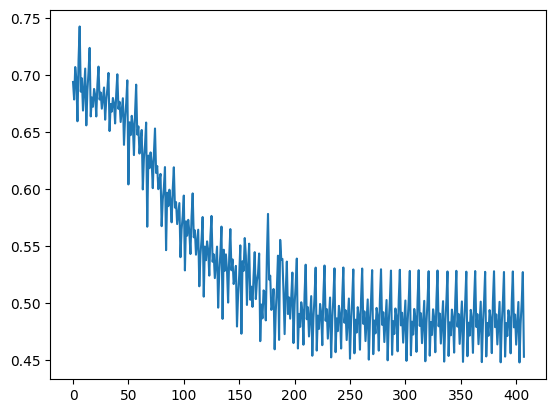

In [149]:
plt.plot(loss_list)

In [132]:
thresholds = np.linspace(0,1,21)

In [137]:
test_loaded = DataLoader(dataset=test)
matrix = np.zeros((2,2),dtype=np.int64)
tp = 0
tn = 0
fn = 0
fp = 0  
for X_batch, y_batch in test_loaded:  
    prediction = model.forward(X_batch)
    if prediction > 0.5: 
        prediction = 1
    else:
        prediction = 0
    if trc.tensor(prediction) == 1 and y_batch[0] == 1:
        tp += 1
    elif trc.tensor(prediction) == 1 and y_batch[0] == 0:
        fp += 1
    elif trc.tensor(prediction) == 0 and y_batch[0] == 1:
        fn += 1
    elif trc.tensor(prediction) == 0 and y_batch[0] == 0:
        tn += 1
matrix[0,0]=tn
matrix[0,1]=fp
matrix[1,0]=fn
matrix[1,1]=tp
print(matrix)


[[ 73 110]
 [ 88 107]]


In [142]:
print('Accuracy is:', (matrix[0,0]+matrix[1,1])/test.__len__())
print('Precision is', (matrix[1,1]/(matrix[0,1]+matrix[1,1])))
print('Recall is', (matrix[1,1]/(matrix[1,0]+matrix[1,1])))

Accuracy is: 0.47619047619047616
Precision is 0.4930875576036866
Recall is 0.5487179487179488


# _______________________________

#### Improving the model 

###### First tentative: smaller batch size

In [150]:
model1 = NewsClassifier(len(vocabulary), 10000)
optimizer_batch = trc.optim.Adam(model1.parameters(), lr=0.001) 
criterion = trc.nn.BCEWithLogitsLoss()

bsize = 50
train_loaded = DataLoader(dataset=train, batch_size=bsize)

loss_list1 = []
avg_loss_list = []
n_epochs = 25

for epoch in range(1,n_epochs):
  for X_batch, y_batch in train_loaded:
      optimizer_batch.zero_grad()
      prediction = model1.forward(X_batch)
      loss = criterion(prediction, trc.reshape(y_batch, (len(prediction),1)).float())    
      loss.backward() 
      optimizer_batch.step()
      loss_list1.append(loss.item())
      
      print('\repoch: {}\tLoss =  {:.3f}'.format(epoch, loss), end='')
  print('\n')

epoch: 1	Loss =  0.671

epoch: 2	Loss =  0.633

epoch: 3	Loss =  0.564

epoch: 4	Loss =  0.513

epoch: 5	Loss =  0.474

epoch: 6	Loss =  0.462

epoch: 7	Loss =  0.460

epoch: 8	Loss =  0.455

epoch: 9	Loss =  0.454

epoch: 10	Loss =  0.454

epoch: 11	Loss =  0.453

epoch: 12	Loss =  0.453

epoch: 13	Loss =  0.452

epoch: 14	Loss =  0.452

epoch: 15	Loss =  0.452

epoch: 16	Loss =  0.452

epoch: 17	Loss =  0.452

epoch: 18	Loss =  0.452

epoch: 19	Loss =  0.452

epoch: 20	Loss =  0.452

epoch: 21	Loss =  0.452

epoch: 22	Loss =  0.452

epoch: 23	Loss =  0.452

epoch: 24	Loss =  0.452



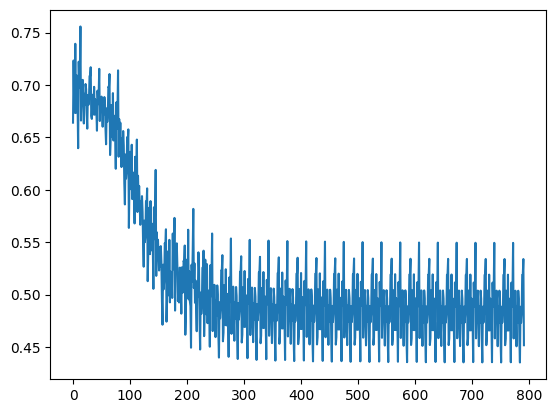

In [151]:
plt.plot(loss_list1)

Smaller batchsize implies faster convergence, as to say we need fewer iterations to retrieve a good optimization over loss. 

Now we have two possible ways to improve our results:
1) Reingeneer the dataset: smaller vocabulary using IDF distribution, CountVectorizer instead of TFIDF
2) Redesign the model adding layers or modifying the activation functions 
3) Find a feature engineer that allows us to build a CNN, that will highlight the localty property of some bags of words

### Future works

1) Multinomial classification defining more complex labels, with respect to the range of the variation. 0-class is no change, 1-class is small negative change, 2-class is meltdown, 3-class is small positive change, 4-class is a glorious day for stock market. We can define this new labels with respect to the distribution of the variations between closing and opening index. 